# AI Music Generator
A Deep Learning Project to generate music using Recurrent Neural Networks 
trained on Maestro dataset from Google.
## Installs

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

## Imports

In [3]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
_SAMPLING_RATE = 16000

In [5]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 [==============================] - 3s 0us/step


## Sample File

In [7]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)
filenames = glob.glob(str(data_dir/'**/*.mid*'))
sample_file = filenames[1]
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

## First 25 Notes
The entire song is a compilation of multiple notes, each of which has three properties: pitch, name, and duration.

In [9]:
instrument = pm.instruments[0]
for i, note in enumerate(instrument.notes[:25]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=65, note_name=F4, duration=1.0469
1: pitch=50, note_name=D3, duration=1.1380
2: pitch=62, note_name=D4, duration=1.1484
3: pitch=64, note_name=E4, duration=0.3477
4: pitch=60, note_name=C4, duration=0.3555
5: pitch=69, note_name=A4, duration=2.2760
6: pitch=59, note_name=B3, duration=0.7331
7: pitch=62, note_name=D4, duration=0.8112
8: pitch=52, note_name=E3, duration=0.7734
9: pitch=68, note_name=G#4, duration=0.3789
10: pitch=55, note_name=G3, duration=0.9049
11: pitch=70, note_name=A#4, duration=0.9206
12: pitch=67, note_name=G4, duration=1.0586
13: pitch=65, note_name=F4, duration=0.2695
14: pitch=69, note_name=A4, duration=0.3203
15: pitch=74, note_name=D5, duration=2.2383
16: pitch=67, note_name=G4, duration=0.8828
17: pitch=57, note_name=A3, duration=0.8555
18: pitch=73, note_name=C#5, duration=0.8620
19: pitch=64, note_name=E4, duration=1.4180
20: pitch=65, note_name=F4, duration=0.3685
21: pitch=77, note_name=F5, duration=0.7370
22: pitch=62, note_name=D4, duration=0.

## Extract all notes in the MIDI files

In [52]:
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)
  # Sorting the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start
  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start
  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,69,0.997396,3.273438,0.000000,2.276042
1,62,1.020833,2.169271,0.023438,1.148437
2,65,1.022135,2.069010,0.001302,1.046875
3,50,1.023438,2.161458,0.001302,1.138021
4,60,1.947917,2.303385,0.924479,0.355469


## Plot Piano Roll of first 50 Notes

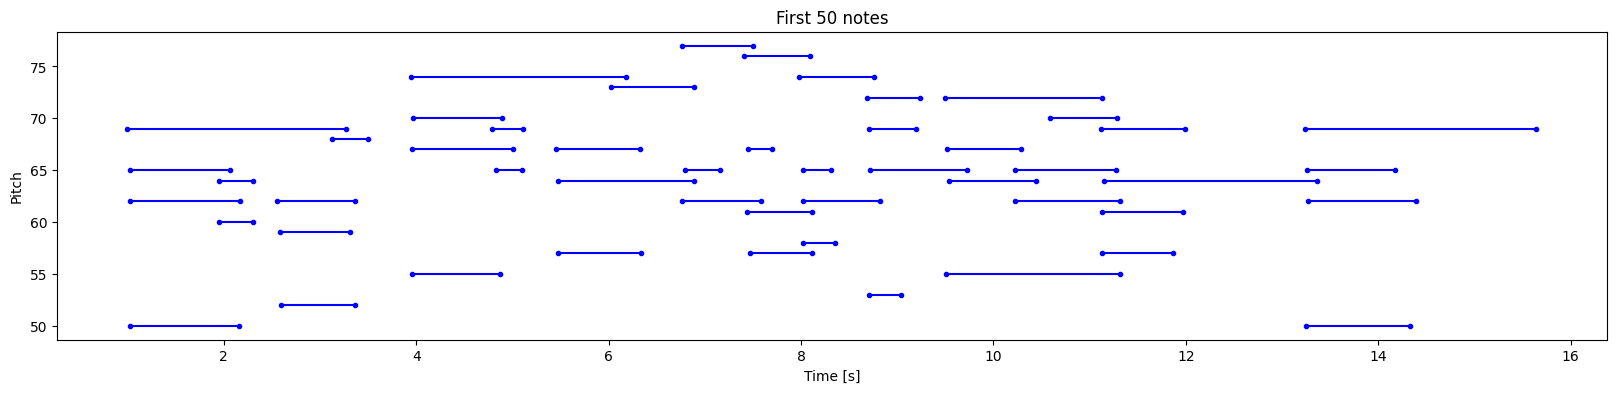

In [12]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)
plot_piano_roll(raw_notes, count=50)

## Sample Generated File

In [64]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)
display_audio(example_pm)

## Creating Training Data Set

Note: This may take a significant amount of time. For this, we have set the num_files to 5 to ensure a relatively faster process. 

In [32]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)
all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [26]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True) #1 extra for the labels
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  def scale_pitch(x):#Normalizing
    x = x/[vocab_size,1.0,1.0]
    return x

  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}
    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [35]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Building the Model

In [36]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [38]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=loss, optimizer=optimizer)
losses = model.evaluate(train_ds, return_dict=True)
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)
model.summary()

384/384 [==============================] - 15s 21ms/step - loss: 6.6624 - duration_loss: 1.6236 - pitch_loss: 4.8608 - step_loss: 0.1780
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          67584       ['input_2[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_1[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          1

In [59]:
model.evaluate(train_ds, return_dict=True)

384/384 [==============================] - 15s 29ms/step - loss: 0.1730 - duration_loss: 0.0157 - pitch_loss: 2.9646 - step_loss: 0.0091


{'loss': 0.1730417162179947,
 'duration_loss': 0.015729980543255806,
 'pitch_loss': 2.9646244049072266,
 'step_loss': 0.009080532938241959}

## Training the Model
This may take 3-5 minutes

In [69]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [70]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
384/384 [==============================] - 24s 62ms/step - loss: 0.1649 - duration_loss: 0.0154 - pitch_loss: 2.8359 - step_loss: 0.0076
Epoch 2/50
384/384 [==============================] - 21s 54ms/step - loss: 0.1618 - duration_loss: 0.0139 - pitch_loss: 2.8023 - step_loss: 0.0078
Epoch 3/50
384/384 [==============================] - 23s 59ms/step - loss: 0.1599 - duration_loss: 0.0133 - pitch_loss: 2.7823 - step_loss: 0.0075
Epoch 4/50
384/384 [==============================] - 21s 54ms/step - loss: 0.1592 - duration_loss: 0.0131 - pitch_loss: 2.7745 - step_loss: 0.0073
Epoch 5/50
384/384 [==============================] - 21s 55ms/step - loss: 0.1615 - duration_loss: 0.0141 - pitch_loss: 2.7939 - step_loss: 0.0077
Epoch 6/50
384/384 [==============================] - 20s 51ms/step - loss: 0.1591 - duration_loss: 0.0138 - pitch_loss: 2.7539 - step_loss: 0.0076
Epoch 7/50
384/384 [==============================] - 20s 52ms/step - loss: 0.1573 - duration_loss: 0.0133 - pit

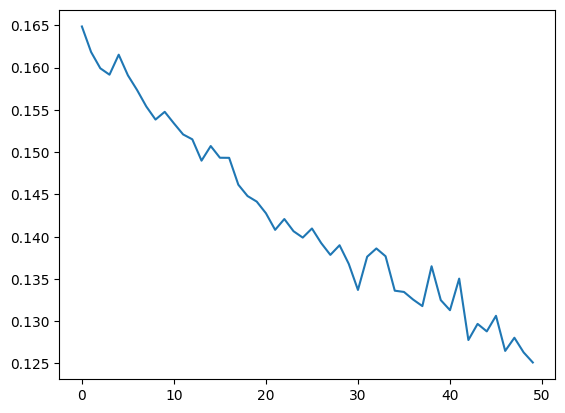

In [71]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generating Songs

In [72]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [77]:
temperature = 1.0
num_predictions = 360

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))
generated_notes.head(10)

1/1 [==============================] - 0s 25ms/step


,pitch,step,duration,start,end
0,79,0.109403,0.367271,0.109403,0.476675
1,84,0.040294,0.197988,0.149697,0.347685
2,72,0.045820,0.180912,0.195517,0.376429
3,72,0.051231,0.159185,0.246748,0.405933
4,81,0.045603,0.184375,0.292351,0.476726
5,72,0.050467,0.148742,0.342817,0.491559
6,81,0.048625,0.153322,0.391443,0.544764
7,84,0.035720,0.242377,0.427163,0.669540
8,72,0.034224,0.236327,0.461387,0.697714
9,84,0.040862,0.209000,0.502249,0.711249


In [78]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)